# Data Madness - Group 3 

## Advice for Newcastle FC: Analysis of the European Football Transfer Market.

The data has been scrapped from Transfermarkt (https://www.transfermarkt.com/) and the English Premier League official website (https://www.premierleague.com/stats/top/players).The datasets for the transfers and player statistics has been made receptively.

The questions that have been answered during this project include: 
 
Has Newcastle FC overpaid for the transfers completed in the winter window of season 2021/2022?  

Which teams have the best transfer policies? 

In [ ]:
# all necessary libraries 
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Scraping

The reviewer of this code does not need to run the scraping cells as it requires the change of multiple links both for obtaining transfer and player statistics datasets.Instead,the datasets which are fully scrapped from scratch will be uploaded as a csv.(the final version of datasets being used for the analyses)

### Scraping Transfer Data from Transfermarkt

The cells below have been used to scrap the data from the Transfermarkt.Only the year has been changed to get the corresponding year transfers.Only transfers In(coming to the English club) has been kept in the final datasets.Also the in clubs have been added manually by creating corresponding csv. 

In [ ]:

headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/605.1.15 (KHTML, like Gecko) Safari/605.1.15 Version/13.0.4"}

page = "https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1/plus/?saison_id=2019&s_w=&leihe=0&intern=0"
pageTree = requests.get(page,headers = headers)
transferSoup = BeautifulSoup(pageTree.content, "html.parser")

playerList = []
nationList = []
ageList = []
positionList = []
marketValuesList = []
leavingClubsList = []
feeList= []
players_df = pd.DataFrame()

players = transferSoup.find_all("div", {"class": "di nowrap"})
nationality = transferSoup.find_all("td", {"class": "zentriert nat-transfer-cell"})
age = transferSoup.findAll("td",{"class":"zentriert alter-transfer-cell"})
positions = transferSoup.find_all("td",{"class":"pos-transfer-cell"})
marketValues = transferSoup.find_all("td",{"class":"rechts mw-transfer-cell"})
leavingClubs = transferSoup.find_all("td",{"class":"no-border-links verein-flagge-transfer-cell"})
fees = transferSoup.find_all("td",{"class":"rechts"})

for i in range(len(age)):
    ageList.append(age[i].text)
    positionList.append(positions[i].text)
    marketValuesList.append(marketValues[i].text)
for i in range(1,len(age)*2,2):
    feeList.append(fees[i].text)
for i in range(len(nationality)):
    nation = str(nationality[i])
    nation = nation.split(" ")[-1].split('"')[1]
    nationList.append(nation)
for i in range(len(leavingClubs)):
    leavingClub = str(leavingClubs[i])
    leavingClub = leavingClub.split("title")[-1]
    start = leavingClub.find(">") + 1
    end = leavingClub.find("<")
    leavingClub = leavingClub[start:end]
    leavingClubsList.append(leavingClub)
playerListDup = []
for i in range(len(players)):
    player = str(players[i])
    player = player.split("title")[-1]
    start = player.find(">") + 1
    end = player.find("<")
    player = player[start:end]
    playerListDup.append(player)
for i in range(0,len(playerListDup),2):
    playerList.append(playerListDup[i])

transfers = pd.DataFrame(list(zip(playerList,leavingClubsList,ageList,nationList,positionList,marketValuesList,feeList)),
            columns =['Name',"Out",'Age',"Nationality","Position","Market_Value","Transfer_Fee"])
#transfers



### Scraping Player Statistics from English Premiere League official website.

The player statistics has been obtained running the script below for each player changing the link each time.The name correspondence has been done manually ,checking that all players are in both the transfer and player statistics dataset.

In [ ]:
#The link to the player statistics needs to be changed each time while running the code 
#to get the dataset below
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/605.1.15 (KHTML, like Gecko) Safari/605.1.15 Version/13.0.4"}

page = "https://www.premierleague.com/players/5061/Andr%C3%A9-Gomes/stats"
pageTree = requests.get(page,headers = headers)
playerSoup = BeautifulSoup(pageTree.content, "html.parser")


player_top_stats = playerSoup.find_all("div", {"class": "topStat"})
player_stats = playerSoup.find_all("div", {"class": "normalStat"})
player_name = playerSoup.find("meta", property="og:title")
player_name_list = str(player_name).replace('"'," ").split(" ")
player_name = player_name_list[2] + " " +  player_name_list[3]
player_pos = playerSoup.find_all("div", {"class": "info"})[-1].text
players_df = pd.DataFrame()

player_profile = dict()
player_profile["Name"] = player_name
player_profile["Position"] = player_pos


In [ ]:
for i in range(len(player_top_stats)):
    player_top_stats[i] = player_top_stats[i].text.replace("\n"," ").strip()
    key = player_top_stats[i].split("         ")[0]
    value = player_top_stats[i].split("         ")[1]
    value = value.strip()
    player_profile[key] = value
    
for i in range(len(player_stats)):
    player_stats[i] = player_stats[i].text.replace("\n"," ").strip()
    key = player_stats[i].split("         ")[0]
    value = player_stats[i].split("         ")[1]
    value = value.strip()
    player_profile[key] = value

player_df = pd.DataFrame(player_profile, index = [0])
players_df = players_df.append(player_df)
#players_df

In [ ]:
#Loading the players and transfers final datasets
data_players=pd.read_csv('players.csv')
data_transfers=pd.read_csv('all_transfers_data.csv')

## Data Analysis

In [ ]:
def clean_transfers(dataset):

    dataset['Market_Value'] = dataset['Market_Value'].str[1:].str[:-1]
    dataset['Transfer_Fee'] = dataset['Transfer_Fee'].str[1:].str[:-1]

    for index, value in dataset['Market_Value'].items():
        if value.endswith('Th'):
            # convert to million
            dataset.loc[index, 'Market_Value'] = int(value[:-2])/1000

    for index, value in dataset['Transfer_Fee'].items():
        if value.endswith('Th'):
            # convert to million
            dataset.loc[index, 'Transfer_Fee'] = int(value[:-2])/1000

    dataset['Market_Value'] = pd.to_numeric(dataset['Market_Value'], downcast='float')
    dataset['Transfer_Fee'] = pd.to_numeric(dataset['Transfer_Fee'], downcast='float')

    return dataset

In [ ]:
data_transfers = clean_transfers(data_transfers)

### Newcastle Transfers for the previous season

In [ ]:
#The transfers which Newcastle made in year 2021-2022
data_newcastle=data_transfers.loc[data_transfers['In'] == 'Newcastle']
data_newcastle_2122=data_newcastle.loc[data_newcastle['Season']=='2021 - 2022']

In [ ]:
data_newcastle_2122

,Name,In,Out,Age,Nationality,Position,Market_Value,Transfer_Fee,Season
36,Bruno Guimarães,Newcastle,Olympique Lyon,24,Spain,Defensive Midfield,30.0,42.099998,2021 - 2022
42,Chris Wood,Newcastle,Burnley,30,New Zeland,Centre-Forward,6.0,30.000000,2021 - 2022
52,Dan Burn,Newcastle,Brighton,29,England,Centre-Back,3.5,15.000000,2021 - 2022
122,Joe Willock,Newcastle,Arsenal,21,Montserrat,Central Midfield,22.0,29.400000,2021 - 2022
141,Kieran Trippier,Newcastle,Atlético Madrid,31,England,Right-Back,18.0,15.000000,2021 - 2022


### Volatility in the Football Transfer Market
The market value of a player in our dataset is determined by the Transfermarkt GmbH based on the transfer fees paid in the past and the player's current salary. Some financial attributes of the transaction are also considered such as:
- Loan fees
- Marketing values
- Buyback options
We want to see how this evaluation relates to the transfers of the 2021-2022 season of the top clubs in the premier league to see which clubs deviate the most from the estimated values of the players in their purchase decisions.

In [ ]:
data_transfers['Deviation'] = (data_transfers['Transfer_Fee'] - data_transfers['Market_Value'])*100/data_transfers['Market_Value']

In [ ]:
data_transfers['In'].unique()

array(['Brighton', 'Arsenal', 'Sheff Utd', 'Man Utd', 'Everton',
       'Southampton', 'West Ham', 'Newcastle', 'Man City', 'Norwich',
       'Fulham', 'Aston VIlla', 'Burnemouth', 'Leicester', 'Burnley',
       'Chelsea', 'Liverpool', 'Wolves', 'Aston Villa', 'Tottenham',
       'West Brom', 'Brentford', 'Watford', 'Leeds', 'Crystal Palace'],
      dtype=object)

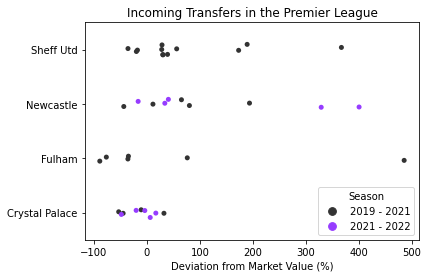

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title('Incoming Transfers in the Premier League')

data = data_transfers

colors = ['#333','#963cff']

seasons_dict = dict({'2019 - 2021': colors[0],
                    '2021 - 2022': colors[1]})

data.Season = data.Season.replace('2019 - 2020', '2019 - 2021')
data.Season = data.Season.replace('2020 - 2021', '2019 - 2021')

data = data[data.In.isin(['Brighton', 'Arsenal', 'Sheff Utd', 'Man Utd', 'Everton',
       'Southampton', 'West Ham', 'Newcastle', 'Man City', 'Norwich',
       'Fulham', 'Aston VIlla', 'Burnemouth', 'Leicester', 'Burnley',
       'Chelsea', 'Liverpool', 'Wolves', 'Aston Villa', 'Tottenham',
       'West Brom', 'Brentford', 'Watford', 'Leeds', 'Crystal Palace'])]
ax = sns.stripplot(x="Deviation", y="In", hue="Season", palette=seasons_dict, data=data)


plt.ylabel('')
plt.xlabel('Deviation from Market Value (%)')
plt.savefig('top_clubs.png', dpi=300, bbox_inches='tight')
plt.show()

While some of the top teams in the premier league pay up to 200% the currently estimated market value for a player, **Newcastle** has bought **Dan Burn** and **Chris Wood** at **4x** and **5x** their **valuation**. For the other three players, they seem to not have overpaid considering their strategy for the previous transfer seasons. This volatility seems to be aligned with the other premier league clubs. To see if the two outlier purchases are justified, we will model the value of these players ourselves using the statistics that we collected earlier from the premier league website.

### Player Evaluation Model for the Premier League

In [ ]:
#Loading the players and transfers final datasets
data_players=pd.read_csv('players.csv')
data_transfers=pd.read_csv('all_transfers_data.csv')

In [ ]:
#The transfers which Newcastle made in year 2021-2022
data_newcastle=data_transfers.loc[data_transfers['In'] == 'Newcastle']
data_newcastle_2122=data_newcastle.loc[data_newcastle['Season']=='2021 - 2022']

In [ ]:
data_transfers = clean_transfers(data_transfers)
data_newcastle_2122=clean_transfers(data_newcastle_2122)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be 

### Adding transfer fee and Market Value to player Statistics

In [ ]:
data_players = data_players.set_index('Name')
data_players = data_players[~data_players.index.duplicated(keep='first')]
data_transfers = data_transfers.set_index('Name')
data_transfers = data_transfers[~data_transfers.index.duplicated(keep='first')]
data_newcastle_2122 = data_newcastle_2122.set_index('Name')
data_newcastle_2122 = data_newcastle_2122[~data_newcastle_2122.index.duplicated(keep='first')]

In [ ]:
data_name_trans=data_transfers[['Transfer_Fee','Market_Value']]

In [ ]:
data_merged=pd.merge(data_players, data_name_trans, left_index=True, right_index=True)

### Splitting dataframe based on Position

In [ ]:
data=data_merged
#create unique list of names
UniqueNames = data.Position.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.Position == key]

In [ ]:
data_Midfielder=DataFrameDict['Midfielder']
data_Goalkeeper=DataFrameDict['Goalkeeper']
data_Defender=DataFrameDict['Defender']
data_Forward=DataFrameDict['Forward']
data_Midfielder=data_Midfielder.drop('Position',axis=1)
data_Goalkeeper=data_Goalkeeper.drop('Position',axis=1)
data_Defender=data_Defender.drop('Position',axis=1)
data_Forward=data_Forward.drop('Position',axis=1)
data_Midfielder=data_Midfielder.apply(pd.to_numeric, errors='coerce')
data_Goalkeeper= data_Goalkeeper.apply(pd.to_numeric, errors='coerce')
data_Defender= data_Defender.apply(pd.to_numeric, errors='coerce')
data_Forward= data_Forward.apply(pd.to_numeric, errors='coerce')

### Model on Midfielder

In [ ]:
a=data_Midfielder[['Goals', 'Wins', 'Losses', 'Clean sheets',
       'Goals Conceded', 'Tackles','Last man tackles',
       'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big Chances Created', 'Crosses','Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Headed goals',
       'Goals with right foot', 'Goals with left foot', 'Hit woodwork',
       'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots',
       'Shots on target','Big chances missed', 'Saves',
       'Penalties Saved', 'Punches', 'High Claims', 'Catches',
       'Sweeper clearances', 'Throw outs', 'Goal Kicks']].div(data_Midfielder.Appearances,axis=0)

In [ ]:
for col in a:
    data_Midfielder[col]=a[col]

### Predicting the transfer fee Using Linear Regression

In [ ]:
for col in data_Midfielder.columns:
    missing=data_Midfielder[col].isna().sum()
    if(missing>=45):
        data_Midfielder=data_Midfielder.drop([col],axis=1)

In [ ]:
data_Midfielder=data_Midfielder.drop(['Appearances'],axis=1)
X_Midfielder=data_Midfielder.drop(['Transfer_Fee'],axis=1)
y_Midfielder=data_Midfielder['Transfer_Fee']
data_Midfielder=data_Midfielder.fillna(0)

In [ ]:
data_Midfielder=data_Midfielder.fillna(0)
train_data_Midfielder=data_Midfielder.drop(['Bruno Guimarães','Joe Willock'])
data_Midfielder=data_Midfielder.reset_index() 
test_data_Midfielder=data_Midfielder[(data_Midfielder['Name'] == 'Bruno Guimarães') | (data_Midfielder['Name'] == 'Joe Willock' )]
X_Midfielder_train=train_data_Midfielder.drop(['Transfer_Fee'],axis=1)
y_Midfielder_train=train_data_Midfielder['Transfer_Fee']
X_Midfielder_test=test_data_Midfielder.drop(['Transfer_Fee','Name'],axis=1)
y_Midfielder_test=test_data_Midfielder['Transfer_Fee']
reg = LinearRegression().fit(X_Midfielder_train, y_Midfielder_train)
y_pred_train_Midfielder=reg.predict(X_Midfielder_train)
y_pred_test_Midfielder=reg.predict(X_Midfielder_test)
y_pred_train_Midfielder = ['{:f}'.format(item) for item in y_pred_train_Midfielder]
y_pred_train_Midfielder=pd.DataFrame(y_pred_train_Midfielder)
y_pred_test_Midfielder=pd.DataFrame(y_pred_test_Midfielder)

### Model on Defender

In [ ]:
b=data_Defender[['Goals', 'Wins', 'Losses', 'Clean sheets',
       'Goals Conceded', 'Tackles','Last man tackles',
       'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big Chances Created', 'Crosses','Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Headed goals',
       'Goals with right foot', 'Goals with left foot', 'Hit woodwork',
       'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots',
       'Shots on target','Big chances missed', 'Saves',
       'Penalties Saved', 'Punches', 'High Claims', 'Catches',
       'Sweeper clearances', 'Throw outs', 'Goal Kicks']].div(data_Defender.Appearances,axis=0)

In [ ]:
for col in b:
    data_Defender[col]=b[col]

In [ ]:
for col in data_Defender.columns:
    missing=data_Defender[col].isna().sum()
    if(missing>=45):
        data_Defender=data_Defender.drop([col],axis=1)

In [ ]:
data_Defender=data_Defender.drop(['Appearances'],axis=1)
X_Defender=data_Defender.drop(['Transfer_Fee'],axis=1)
y_Defender=data_Defender['Transfer_Fee']
data_Defender=data_Defender.fillna(0)
train_data_Defender=data_Defender.drop(['Kieran Trippier','Dan Burn'])
data_Defender=data_Defender.reset_index() 
test_data_Defender=data_Defender[(data_Defender['Name'] == 'Kieran Trippier') | (data_Defender['Name'] == 'Dan Burn' )]
X_Defender_train=train_data_Defender.drop(['Transfer_Fee'],axis=1)
y_Defender_train=train_data_Defender['Transfer_Fee']
X_Defender_test=test_data_Defender.drop(['Transfer_Fee','Name'],axis=1)
y_Defender_test=test_data_Defender['Transfer_Fee']

In [ ]:
reg = LinearRegression().fit(X_Defender_train, y_Defender_train)
y_pred_train_Defender=reg.predict(X_Defender_train)
y_pred_test_Defender=reg.predict(X_Defender_test)
y_pred_train_Defender = ['{:f}'.format(item) for item in y_pred_train_Defender]
y_pred_train_Defender=pd.DataFrame(y_pred_train_Defender)
y_pred_test_Defender=pd.DataFrame(y_pred_test_Defender)

### Model on Forward

In [ ]:
c=data_Forward[['Goals', 'Wins', 'Losses', 'Clean sheets',
       'Goals Conceded', 'Tackles','Last man tackles',
       'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big Chances Created', 'Crosses','Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Headed goals',
       'Goals with right foot', 'Goals with left foot', 'Hit woodwork',
       'Goals per match', 'Penalties scored', 'Freekicks scored', 'Shots',
       'Shots on target','Big chances missed', 'Saves',
       'Penalties Saved', 'Punches', 'High Claims', 'Catches',
       'Sweeper clearances', 'Throw outs', 'Goal Kicks']].div(data_Forward.Appearances,axis=0)

In [ ]:
for col in c:
    data_Forward[col]=c[col]

for col in data_Forward.columns:
    missing=data_Forward[col].isna().sum()
    if(missing>=45):
        data_Forward=data_Forward.drop([col],axis=1)

In [ ]:
data_Forward=data_Forward.drop(['Appearances'],axis=1)
data_Forward=data_Forward.fillna(0)
train_data_Forward=data_Forward.drop(['Chris Wood'])
data_Forward=data_Forward.reset_index() 
test_data_Forward=data_Forward[data_Forward['Name'] == 'Chris Wood']
X_Forward_train=train_data_Forward.drop(['Transfer_Fee'],axis=1)
y_Forward_train=train_data_Forward['Transfer_Fee']
X_Forward_test=test_data_Forward.drop(['Transfer_Fee','Name'],axis=1)
y_Forward_test=test_data_Forward['Transfer_Fee']

In [ ]:
reg = LinearRegression().fit(X_Forward_train, y_Forward_train)
y_pred_train_Forward=reg.predict(X_Forward_train)
y_pred_test_Forward=reg.predict(X_Forward_test)
y_pred_train_Forward = ['{:f}'.format(item) for item in y_pred_train_Forward]
y_pred_train_Forward=pd.DataFrame(y_pred_train_Forward)
y_pred_test_Forward=pd.DataFrame(y_pred_test_Forward)

The model has some limitations but can be developed further if more data(player statistics and transfers) will be added.

### Predictions and Actual Transfer fee

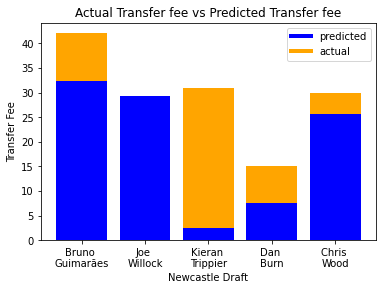

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

Football_player = ['Bruno \nGuimarães','Joe \nWillock','Kieran \nTrippier','Dan \nBurn','Chris \nWood']
Actual_transfer_fee=[42.099998474121094,21,31,15 ,30]
Predicted_transfer_fee=[32.40216538811653,29.404011204821085,2.5741798258806505,7.489077564749387,25.62686154606623]

ax.bar(Football_player,Actual_transfer_fee, color='orange')
ax.bar(Football_player,Predicted_transfer_fee, color='blue')

legend_elements = [Line2D([0], [0], color='blue', lw=4, label='predicted'),
                    Line2D([0], [0], color='orange', lw=4, label='actual')]
ax.legend(handles=legend_elements)

plt.title('Actual Transfer fee vs Predicted Transfer fee')
plt.xlabel('Newcastle Draft')
plt.ylabel('Transfer Fee')
plt.show()

Looking at the predictions and actual transfers fee it can be concluded that the Newcastle overpaid for the new transfers in the season 2021-2022.

## Data Ethics for Sport Transfers

The data which has been used for this project includes the number of goals, wins, losses, and other statistics collected during the football match. This information is publicly available as it does not contain any sensible data and can be used for different purposes including study and research purposes as well. Besides, football teams gather sensible data about the football players including the training details, the meal plan of football players, sleeping hours, daily routine, and a few more. This data is available only between the football coach and player and is not available to the public.(https://www.wired.com/story/the-tricky-ethics-of-the-nfls-new-open-data-policy/) The data which has been scrapped from Transfermarkt is publicly available and transfer fee and market value are also transparent information to be used. The websites which have been used to scrap the data make it explicit that the data use and scrapping are legal as stated in their *'robots.txt'* file:

```
User-agent: Slurp
Crawl-delay: 2

User-agent: Mediapartners-Google
Disallow:

User-agent: wget
Disallow: /

User-agent: *
Allow: /
```

On the other side, data tracking in sports analytics has seen quite some pushbacks from players in the recent years as [The Guardian](https://www.theguardian.com/football/2021/oct/12/hundreds-of-professional-footballers-threaten-action-against-betting-companies) reported five month ago. Players argue that they should be compensated for the use of their personal data according to article 4 of the GDPR. However, according to the article 82 of the GDPR the right to compensation only arises if the person has suffered a material or non-material damage. Contrary to the Guardian article the websites which use the data could prove that they are not damaging the players' reputations or career opportunities by the use of the data and that componsation of the money is not applicable in this situation. In this case, finding the line between personal and professional or financial data to be collected is crucial as we move forward to acquire a wider variety of player related attributes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01de0f3a-b7ba-40e0-8606-4a098a43ff18' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>